### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pathlib
import tensorflow_hub as hub

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.20.0


### Define Dataset Paths and Class Names

In [2]:
train_dir = 'chest_xray/train'  # Path to training dataset
val_dir = 'chest_xray/val'      # Path to validation dataset
test_dir = 'chest_xray/test'    # Path to test dataset

# Detect class names from the training directory
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.is_dir()]))
print("Classes detected:", class_names)

for c in class_names:
    count = len(list(pathlib.Path(train_dir).glob(f'{c}/*.jpeg')))
    print(f'{c}: {count} images')

Classes detected: ['NORMAL' 'PNEUMONIA']
NORMAL: 1341 images
PNEUMONIA: 3875 images


### Data Loaders with Augmentation for Train, Rescaling for Val/Test

In [3]:
batch_size = 32
img_height, img_width = 224, 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 5216 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# Build EfficientNetV2 model with transfer learning
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained EfficientNetV2B0 model without top layers
base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# Freeze the base model layers for transfer learning
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

# Get number of classes from train generator
num_classes = train_generator.num_classes
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model_efficientnetv2 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,083,538 (23.21 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7)

# Unfreeze all layers or a subset for fine-tuning
base_model.trainable = True

model_efficientnetv2.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Continue training
history_finetune = model_efficientnetv2.fit(
    train_generator, validation_data=val_generator,
    epochs=10, callbacks=[early_stop, reduce_lr])


c:\Users\miraz\OneDrive\Documents\GitHub\Chest-X-Ray-Detection\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 664s 4s/step - accuracy: 0.7918 - loss: 0.4860 - val_accuracy: 0.8511 - val_loss: 0.4680 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 653s 4s/step - accuracy: 0.8917 - loss: 0.2909 - val_accuracy: 0.8723 - val_loss: 0.3225 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 650s 4s/step - accuracy: 0.9070 - loss: 0.2388 - val_accuracy: 0.8511 - val_loss: 0.3083 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 707s 4s/step - accuracy: 0.9133 - loss: 0.2097 - val_accuracy: 0.8511 - val_loss: 0.2647 - learning_rate: 1.0000e-05
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 683s 4s/step - accuracy: 0.9264 - loss: 0.1869 - val_accuracy: 0.8936 - val_loss: 0.2091 - learning_rate: 1.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 752s 5s/step - accuracy: 0.9304 - loss: 0.1761 - val_accuracy: 0.8936 - val_loss: 0.2159 - learning_rate: 1.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 641s 4s/step - acc

In [7]:
   
   # Evaluate fine-tuned model on validation set
val_loss, val_acc = model_efficientnetv2.evaluate(val_generator)
print(f'Fine-tuned ResNet50 Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}')

   

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step - accuracy: 0.9574 - loss: 0.1645
Fine-tuned ResNet50 Validation Accuracy: 0.9574, Loss: 0.1645


In [8]:
# Evaluate fine-tuned model on test set for unbiased performance
test_loss, test_acc = model_efficientnetv2.evaluate(test_generator)
print(f'Fine-tuned ResNet50 Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}')


c:\Users\miraz\OneDrive\Documents\GitHub\Chest-X-Ray-Detection\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8413 - loss: 0.3748
Fine-tuned ResNet50 Test Accuracy: 0.8413, Loss: 0.3748


In [9]:
# Save your fine-tuned model for future use or deployment
model_efficientnetv2.save('efficientnetv2_chest_xray_finetuned.h5')
print("Model saved as 'efficientnetv2_chest_xray_finetuned.h5'")

Model saved as 'efficientnetv2_chest_xray_finetuned.h5'


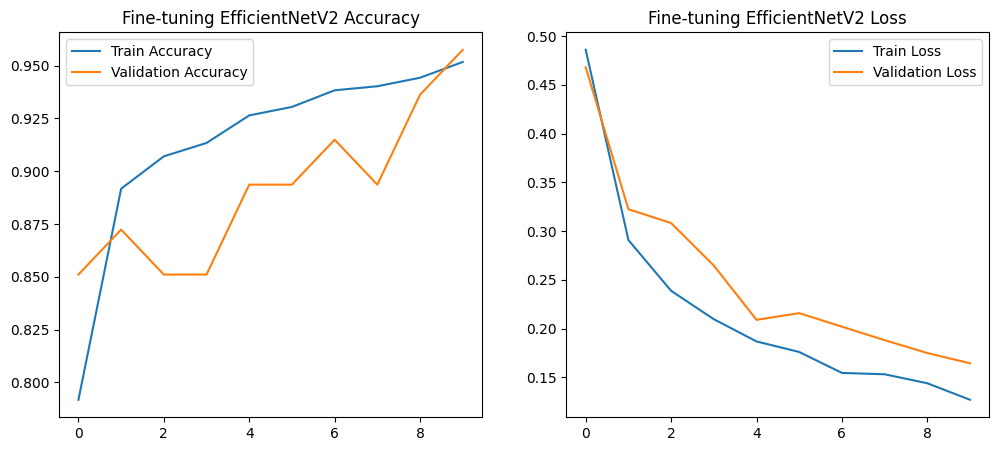

In [10]:
# Plot training and validation accuracy/loss curves for fine-tuning phase
import matplotlib.pyplot as plt

def plot_training(history, title):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title + ' Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title + ' Loss')
    plt.legend()
    
    plt.show()

plot_training(history_finetune, 'Fine-tuning EfficientNetV2')


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 839ms/step


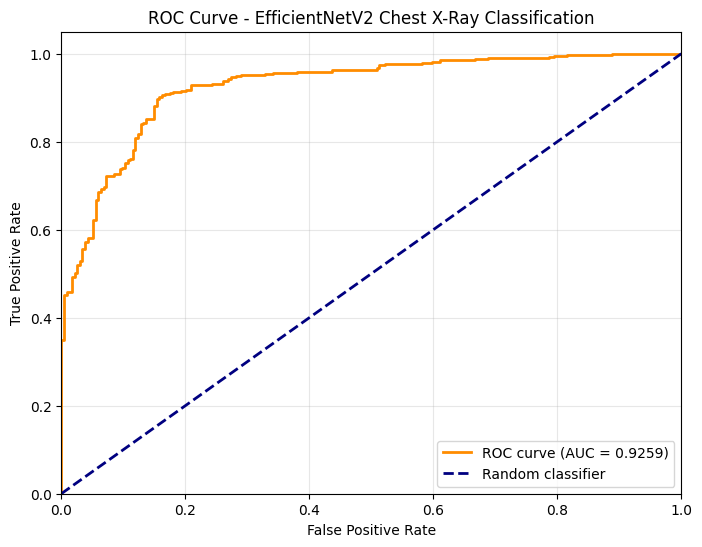

Area Under the ROC Curve (AUC): 0.9259


In [13]:
# Generate ROC Curve for the fine-tuned model
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get predictions on test set
test_predictions = model_efficientnetv2.predict(test_generator)
test_predictions_prob = test_predictions[:, 1]  # Probability of positive class (pneumonia)

# Get true labels
test_generator.reset()
test_labels = []
for i in range(len(test_generator)):
    batch_x, batch_y = test_generator[i]
    test_labels.extend(batch_y[:, 1])  # Get pneumonia labels (assuming binary classification)

test_labels = np.array(test_labels)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - EfficientNetV2 Chest X-Ray Classification')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f'Area Under the ROC Curve (AUC): {roc_auc:.4f}')


Classification Report:
              precision    recall  f1-score   support

      Normal     0.7473    0.8718    0.8047       234
   Pneumonia     0.9145    0.8231    0.8664       390

    accuracy                         0.8413       624
   macro avg     0.8309    0.8474    0.8356       624
weighted avg     0.8518    0.8413    0.8433       624



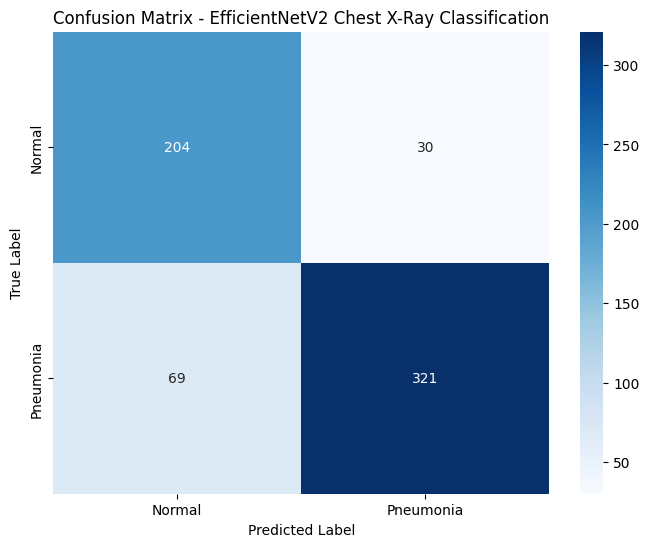


Detailed Metrics:
Accuracy: 0.8413
Precision: 0.9145
Recall (Sensitivity): 0.8231
Specificity: 0.8718
F1-Score: 0.8664


In [14]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get binary predictions (0 or 1)
test_predictions_binary = (test_predictions_prob > 0.5).astype(int)

# Generate classification report
class_names = ['Normal', 'Pneumonia']
report = classification_report(test_labels, test_predictions_binary, 
                             target_names=class_names, 
                             digits=4)

print("Classification Report:")
print("=" * 50)
print(report)

# Generate and plot confusion matrix
cm = confusion_matrix(test_labels, test_predictions_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - EfficientNetV2 Chest X-Ray Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nDetailed Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1_score:.4f}")
